In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

def plot(phi, Lx=1, Ly=1):
    Nx, Ny = phi.shape
    dx, dy = Lx/Nx, Ly/Ny
    fig, ax = plt.subplots(1,1,subplot_kw={'projection':'3d'}, figsize=[10,10])
    x,y = np.meshgrid(dx*np.array(range(Nx)), dy*np.array(range(Ny)))
    r,c = int (np.ceil(0.05/dx)), int (np.ceil(0.05/dy))
    p = ax.plot_surface(x,y,phi,cmap="coolwarm", linewidth=0, rstride=r, cstride=c)
    fig.colorbar(p)
    plt.show()

N = [16,32,64,128,256]
it = [516, 1934, 6854, 23279, 75485]
python_seq_for = np.array([0.8742485046386719, 14.510885953903198, 219.3693721294403, 2000, 100000])
python_seq_vec = np.array([0.044324636459350586, 0.20854973793029785, 1.307302713394165, 12.949373722076416, 325.5163173675537])

nproc = np.array([1,2,3,4])
python_mpi_N64 = np.array([219.3693721294403, 114.50922203063965, 81.88800430297852, 60.287651777267456])
python_mpi_N128_vec = np.array([12.949373722076416, 19.190797805786133, 19.03237533569336, 18.277994871139526])
c_mpi_N256 = np.array([24.241755,15.728780,8.737570,6.29])


N2 = [64,128,256,512]
c_mpi4 = [0.089767,0.663899,6.423456, 90]
c_seq = [0.123220, 1.650990, 24.714844, 354.262848]
python_vec = [1.307302713394165, 12.949373722076416, 325.5163173675537]
python_numba = [0.4371063709259033, 5.9793291091918945, 94.27894997596741]

# L'equazione di Laplace in Python e C
## Vantaggi e svantaggi della parallelizzazione

## Il problema

Risolvere l'equazione di Laplace in una griglia bidimensionale

$$\begin{cases}
\nabla^2 \phi = f(x,y) = 0\\
\phi(x,y) = g(x,y)\quad\text{(boundaries)}
\end{cases}$$


In uno schema alle differenze finite, con griglia $\Delta x = \Delta y = h$, si ottiene

$$\begin{aligned}
\nabla^2 \phi &= \frac{\partial^2\phi(x,y)}{\partial x^2}+\frac{\partial^2\phi(x,y)}{\partial y^2}\\
&= \frac{\phi_{i-1,j} - 2\phi_{i,j} + \phi_{i+1,j}}{h^2}+\frac{\phi_{i,j-1} - 2\phi_{i,j} + \phi_{i,j+1}}{h^2}\\
\end{aligned}
$$

e quindi

$$\phi_{i-1,j} - 4\phi_{i,j} + \phi_{i+1,j}+ \phi_{i,j-1} + \phi_{i,j+1} = 0$$

### Soluzione del problema
Il problema è equivalente a un sistema lineare; la soluzione può essere ottenuta dall'equazione precedente tramite _rilassamento_ iterativo, effettuando per ogni passo
$$\phi_{i,j}^{k+1} = \frac{1}{4} (\phi_{i-1,j}^k + \phi_{i+1,j}^k + \phi_{i,j-1}^k + \phi_{i,j+1}^k)$$

finché
$$\max|\phi^{k+1}-\phi^k|<\delta$$

Si può arrivare alla soluzione più velocemente utilizzando i valori non appena disponibili (**metodo di Gauss-Seidel**).

## Implementazione parallela: domain decomposition

Per l'implementazione parallela si è optato per la scomposizione del dominio su righe.
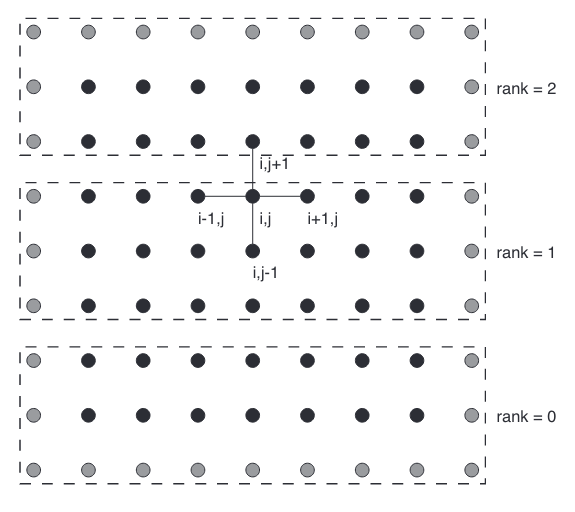

## Implementazione parallela: domain decomposition

dato che i processi devono comunicare i punti tra righe adiacenti, sono state implementate delle _ghost rows_ in ogni dominio locale
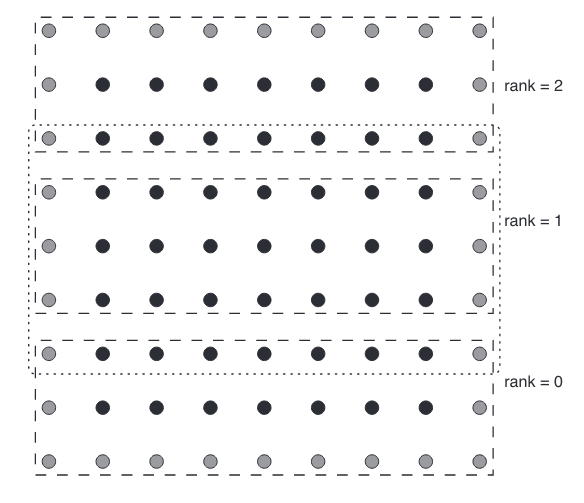

## Implementazione parallela: message passing

Il _message passing_ tra i processi deve essere implementato in quattro fasi:

1. All'inizio, per la **scomposizione del dominio**
2. A ogni step, per la comunicazione dei dati tra **righe adiacenti**
3. A ogni step, per calcolare $\max|\phi^{k+1}-\phi^k|$ sul dominio globale (la **delta**)
4. Alla fine, per **ricomporre il dominio**

## Implementazione parallela: pseudocodice

```python
scomposizione dominio
while(delta<target){
    message passing: righe adiacenti
    iterazione di Jacobi per il dominio locale
    local_delta = max(phi1 - phi) per il dominio locale
    delta = max(local_delta) tra tutti i domini locali
}
ricomposizione dominio
```

## Implementazioni

Sono presentate due diverse implementazioni, nel dettaglio

- Python sequenziale (con cicli for)
- Python parallelo (con `mpi4py`)

Per il confronto sul tempo di calcolo si presentano inoltre

- C sequenziale
- C parallelo (con `MPI`)
- Python vettorizzato (con funzioni di numpy)


### Iterazione di Jacobi (con cicli for)

In [4]:
def solve_laplace_seq(phi):
    phi1 = np.empty(phi.shape)
    delta = 0
    # Calcola i nuovi valori di phi (escludendo le boundaries)
    for i in range(1,phi.shape[0]-1):
        for j in range(1,phi.shape[1]-1):
            phi1[i,j] = (phi[i-1,j] + phi[i+1,j] +\
                        phi[i,j-1] + phi[i,j+1])/4
    # Calcola delta e aggiorna phi
    for i in range(1, phi.shape[0]-1):
        for j in range(1, phi.shape[1]-1):
            diff = np.abs(phi1[i,j]-phi[i,j])
            if (diff>delta):
                delta = diff
            phi[i,j] = phi1[i,j]
    return delta

### Implementazione seriale

In [5]:
Nx, Ny = 32,32
target = 1e-6
# Dominio globale
phi  = np.zeros([Nx,Ny], float)
## Boundary conditions
phi[:,0] = 10

# Solve
delta=1
niter=0
t1 = time()
while delta>target:
    delta = solve_laplace_seq(phi)
    niter += 1
t2 = time()
print(niter, t2-t1)

1934 15.322727918624878


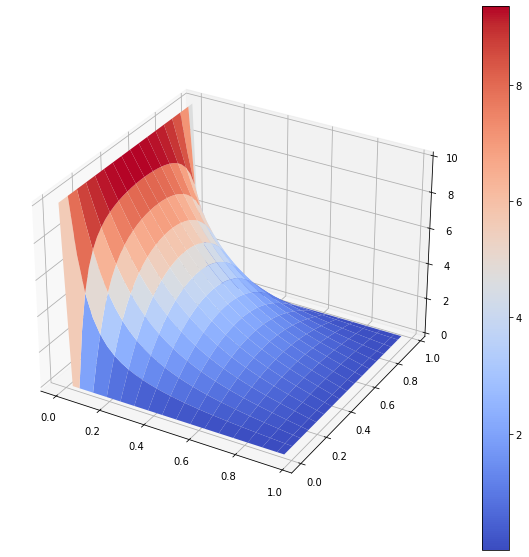

In [6]:
plot(phi)

### Implementazione parallela

In [7]:
Nx, Ny = 16,16
target = 1e-6
# Dominio globale
phi  = np.zeros([Nx,Ny], float)
## Boundary conditions
phi[:,0] = 10

### --> scomposizione del dominio

# Solve
delta=1
niter=0
t1 = time()
while delta>target:
    ### --> message passing dati
    delta = solve_laplace_seq(phi)
    niter += 1
    ### --> message passing delta
t2 = time()
### --> ricomposizione del dominio

### Implementazione parallela: scomposizione del dominio

```python
### --> scomposizione del dominio
## 1. Set number of rows to send to each process
##    last process gets the remaining rows
nx = phi.shape[0] // size
ni = nx * rank
nf = nx * (rank + 1)
if rank == size-1:
    nx += phi.shape[0] % size
    nf += phi.shape[0] % size
## 2. Setup ghost rows for local domain (padding)
pad = ((0,1) if rank==0 else (1,0) if rank==size-1 else (1,1),(0,0))
## 3. Setup local domain
local_phi = np.pad(phi[ni:nf,:], pad, 'constant', constant_values=((0,0),(0,0)))
```

### Implementazione parallela: message passing

```python
while delta>target:
    ### --> message passing dati
    if rank>0:
        comm.Sendrecv(sendbuf=local_phi[1,:], dest=rank-1, sendtag=11,
                      recvbuf=local_phi[0,:], source=rank-1, recvtag=22)
    if rank<size-1:
        comm.Sendrecv(sendbuf=local_phi[-2,:], dest=rank+1, sendtag=22,
                      recvbuf=local_phi[-1,:], source=rank+1, recvtag=11)
    delta = fun_solve(local_phi)
    ### --> message passing delta
    delta = comm.allreduce(delta, op=MPI.MAX)
    niter += 1
```

### Implementazione vettoriale

In [8]:
def solve_laplace_vec(phi):
    # Calc the new values of phi excluding the boundary
    phi1 = (phi[:-2,1:-1] + phi[2:,1:-1] +\
            phi[1:-1,:-2] + phi[1:-1,2:] )/4
    # Calc the max difference between the old and new values
    delta = np.abs(phi1-phi[1:-1,1:-1]).max()
    # Update the values of phi
    phi[1:-1,1:-1] = phi1
    # Return the max difference
    return delta

## Confronto tra le implementazioni: python

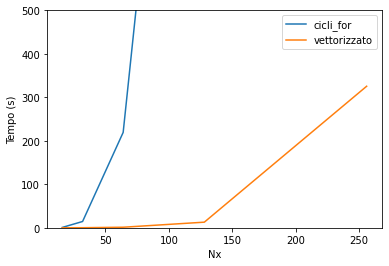

In [9]:
plt.plot(N, python_seq_for, label='cicli_for')
plt.plot(N, python_seq_vec, label='vettorizzato')
plt.xlabel('Nx')
plt.ylabel('Tempo (s)')
plt.ylim([0,500])
plt.legend()

### Speedup (Python)

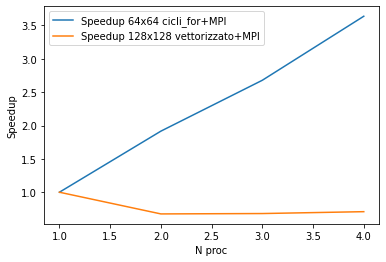

In [10]:
plt.plot(nproc, python_mpi_N64[0]/python_mpi_N64, label='Speedup 64x64 cicli_for+MPI')
plt.plot(nproc, python_mpi_N128_vec[0]/python_mpi_N128_vec, label='Speedup 128x128 vettorizzato+MPI')
plt.xlabel('N proc')
plt.ylabel('Speedup')
plt.legend()

### Speedup (C)

Text(0, 0.5, 'Speedup (256x256)')

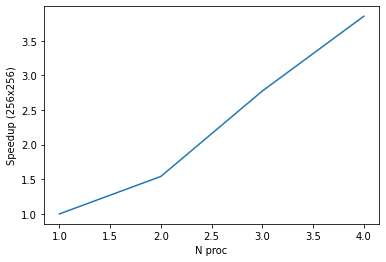

In [11]:
plt.plot(nproc, c_mpi_N256[0]/c_mpi_N256)
plt.xlabel('N proc')
plt.ylabel('Speedup (256x256)')

### Confronto tra le implementazioni: Python vs C

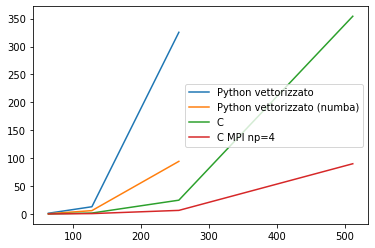

In [12]:
plt.plot(N2[:-1],python_vec,label='Python vettorizzato')
plt.plot(N2[:-1],python_numba,label='Python vettorizzato (numba)')
plt.plot(N2,c_seq,label='C')
plt.plot(N2,c_mpi4,label='C MPI np=4')
plt.legend()